In [13]:
#on importe les bibliothéques
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from data_wrapper import *
from sklearn.model_selection import cross_val_predict,GridSearchCV
import numpy as np

In [ ]:
#données d'entraînement
df1=data_wrapper_j1()
df2=data_wrapper_j2()
df3=data_wrapper_j3()

df12=pd.concat([df1,df2],axis=0)
df123=pd.concat([df12,df3])
df=df123

X_train=np.array(df[df.keys()[7:]].values) # on prend toutes les données du spectre
X_train_n=StandardScaler().fit_transform(X_train)



#  Construction du modèle pour le glucose

In [4]:

y_gluc_true=np.array(df['Glucose'].tolist())

svr_gluc = SVR(kernel='rbf', C=17,gamma='scale',epsilon=.3)

svr_gluc.fit(X_train_n,y_gluc_true)
y_gluc_pred_n=svr_gluc.predict(X_train_n)
MSE_n=mean_squared_error(y_gluc_true,y_gluc_pred_n)
print(f'MSE glucose après normalisation :{MSE_n}')

MSE glucose après normalisation :2.850491815245505


In [5]:
#On effectue une cross-validation

y_pred_gluc_cv=cross_val_predict(svr_gluc,X_train_n,y_gluc_true,cv=5)
MSE=mean_squared_error(y_gluc_true,y_pred_gluc_cv)
print(f'MSE Glucose après normalisation et cross_validation :{MSE}')

MSE Glucose après normalisation et cross_validation :163.17585613079748


In [ ]:
#test pour le glucose
df_test=data_wrapper_j4()

X_test=np.array(df_test[df_test.keys()[7:]].values) # on prend toutes les données du spectre
X_test_n=StandardScaler().fit_transform(X_test)

In [7]:
##### test de prédiction sur le glucose ####
y_test_gluc_true=np.array(df_test['Glucose'].tolist())
y_test_gluc_pred=svr_gluc.predict(X_test_n)

MSE=mean_squared_error(y_test_gluc_true,y_test_gluc_pred)
print(f"MSE sur les données de test pour le glucose:{MSE}")

MSE sur les données de test pour le glucose:123.89686515154828


# Construction du modèle et test pour l'éthanol

In [9]:
## SVR sur l'éthanol ###
y_ethanol_true=np.array(df['Ethanol'].tolist())

svr_eth=SVR(kernel='rbf',C=15,epsilon=0.5,gamma='scale')
svr_eth.fit(X_train_n,y_ethanol_true) 
y_eth_pred=svr_eth.predict(X_train_n)
MSE=mean_squared_error(y_ethanol_true,y_eth_pred)
print(f'MSE Ethanol après normalisation :{MSE}')

MSE Ethanol après normalisation :0.21623112626120533


On effectue une cross-validation pour diminuer l'overfitting

In [10]:
y_pred_eth_cv=cross_val_predict(svr_eth,X_train_n,y_ethanol_true,cv=2,)
MSE=mean_squared_error(y_ethanol_true,y_pred_eth_cv)
print(f'MSE Ethanol après normalisation et cross_validation :{MSE}')

MSE Ethanol après normalisation et cross_validation :19.82668093656519


In [11]:
##### test de prédiction de l'éthanol #####
y_test_eth_true=np.array(df_test['Ethanol'].tolist())
y_test_eth_pred=svr_eth.predict(X_test_n)

MSE=mean_squared_error(y_test_eth_true,y_test_eth_pred)
print(f"MSE sur les données de test pour l'éthanol:{MSE}")

MSE sur les données de test pour l'éthanol:6.672959412935013


# Gridsearch pour optimiser les hyper-paramètres C et epsilon

In [12]:
#liste contenant les valeurs de C et epsilon que l'on veut tester
param_grid={'C':[round(c,2) for c in  np.logspace(-1,3,10)],'epsilon':[round(e,2) for e in np.logspace(-2,1.5,10)]}
SVR_=SVR(kernel='rbf',gamma='scale')

On règle les hyper-paramètres pour l'éthanol à l'aide d'un GridSearchCV

In [14]:
y_true=np.array(df['Ethanol'].tolist())
grid=GridSearchCV(estimator=SVR_,param_grid=param_grid,cv=5,scoring='neg_mean_squared_error')
grid.fit(X_train_n,y_true)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [np.float64(0.1), np.float64(0.28),
                               np.float64(0.77), np.float64(2.15),
                               np.float64(5.99), np.float64(16.68),
                               np.float64(46.42), np.float64(129.15),
                               np.float64(359.38), np.float64(1000.0)],
                         'epsilon': [np.float64(0.01), np.float64(0.02),
                                     np.float64(0.06), np.float64(0.15),
                                     np.float64(0.36), np.float64(0.88),
                                     np.float64(2.15), np.float64(5.27),
                                     np.float64(12.92), np.float64(31.62)]},
             scoring='neg_mean_squared_error')

In [17]:
best_C,best_epsilon=grid.best_params_["C"],grid.best_params_["epsilon"]
svr_grid=SVR(kernel='rbf',gamma='scale',C=best_C,epsilon=best_epsilon)

svr_grid.fit(X_train_n,y_true)
y_pred=cross_val_predict(svr_grid,X_train_n,y_true)
MSE=mean_squared_error(y_true,y_pred)



Le gridsearch donne les hyperparamètres les plus optimisés suivant :

In [18]:
print(f'best C :{best_C}\nbest epsilon : {best_epsilon}')
print(f'best mean square error {MSE}')

best C :129.15
best epsilon : 0.01
best mean square error 13.99605839792038


On va regarder si ces paramètres ont vraiment du sens et sont les paramètres qui vont permettent de généraliser au mieux la prédicton en traçant la Heatmap de la MSE en fonction des hyperparamètres

In [19]:
results=grid.cv_results_


Mat_MSE=np.zeros((10,10))
index_C=[]
col_epsi=[]

compt=-1
for params in  results['params']:
    compt+=1
    i=int(compt/10)
    j=compt%10
    if params['C'] not in index_C:
        index_C.append(params['C'])
    if params['epsilon'] not in col_epsi:
        col_epsi.append(params['epsilon'])
    svr=SVR(kernel='rbf',C=params['C'],epsilon=params['epsilon'],gamma='scale')
    svr.fit(X_train_n,y_true)
    pred=cross_val_predict(svr,X_train_n,y_true,cv=2)
    MSE=mean_squared_error(pred,y_true)
    Mat_MSE[i][j]=round(MSE,2)

df_corr=pd.DataFrame(Mat_MSE,index=index_C,columns=col_epsi)


In [20]:
import seaborn as sns

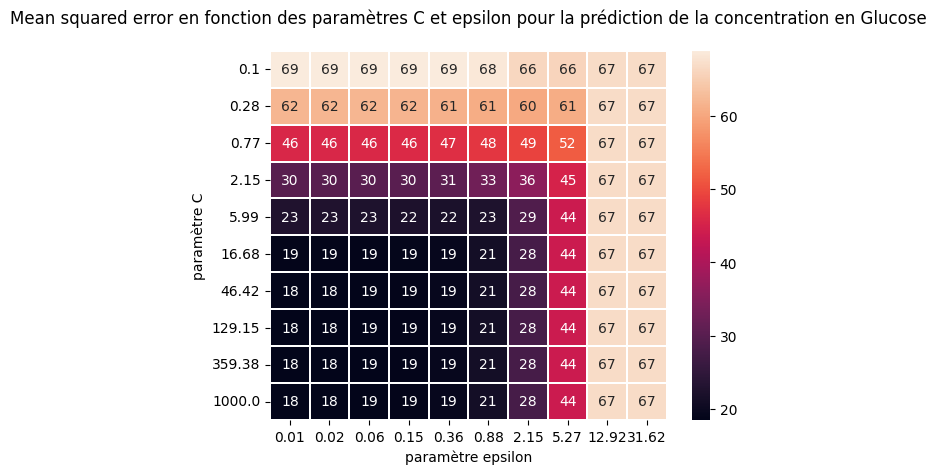

In [21]:
sns.heatmap(df_corr,annot=True,linewidths=.2)
plt.xlabel('paramètre epsilon')
plt.ylabel('paramètre C')
plt.title('Mean squared error en fonction des paramètres C et epsilon pour la prédiction de la concentration en éthanol',y=1.05)
plt.show()

On va donc prendre les hyper-paramètres C=15 et epsilon=0.5

On effectue les mêmes étapes pour déterminer les meilleurs hyper-paramètres pour la concentration en glucoe

In [22]:
y_true=np.array(df['Glucose'].tolist())
grid=GridSearchCV(estimator=SVR_,param_grid=param_grid,cv=5,scoring='neg_mean_squared_error')
grid.fit(X_train_n,y_true)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [np.float64(0.1), np.float64(0.28),
                               np.float64(0.77), np.float64(2.15),
                               np.float64(5.99), np.float64(16.68),
                               np.float64(46.42), np.float64(129.15),
                               np.float64(359.38), np.float64(1000.0)],
                         'epsilon': [np.float64(0.01), np.float64(0.02),
                                     np.float64(0.06), np.float64(0.15),
                                     np.float64(0.36), np.float64(0.88),
                                     np.float64(2.15), np.float64(5.27),
                                     np.float64(12.92), np.float64(31.62)]},
             scoring='neg_mean_squared_error')

In [23]:
best_C,best_epsilon=grid.best_params_["C"],grid.best_params_["epsilon"]
svr_grid=SVR(kernel='rbf',gamma='scale',C=best_C,epsilon=best_epsilon)

svr_grid.fit(X_train_n,y_true)
y_pred=cross_val_predict(svr_grid,X_train_n,y_true)
MSE=mean_squared_error(y_true,y_pred)


In [24]:
print(f'best C :{best_C}\nbest epsilon : {best_epsilon}')
print(f'best mean square error {MSE}')

best C :129.15
best epsilon : 0.01
best mean square error 111.86036139153032


On va regarder si ces paramètres ont vraiment du sens et sont les paramètres qui vont permettent de généraliser au mieux la prédicton en traçant la Heatmap de la MSE en fonction des hyperparamètres

In [32]:
results=grid.cv_results_


Mat_MSE=np.zeros((10,10))
index_C=[]
col_epsi=[]

compt=-1
for params in  results['params']:
    compt+=1
    i=int(compt/10)
    j=compt%10
    if params['C'] not in index_C:
        index_C.append(params['C'])
    if params['epsilon'] not in col_epsi:
        col_epsi.append(params['epsilon'])
    svr=SVR(kernel='rbf',C=params['C'],epsilon=params['epsilon'],gamma='scale')
    svr.fit(X_train_n,y_true)
    pred=cross_val_predict(svr,X_train_n,y_true,cv=2)
    MSE=mean_squared_error(pred,y_true)
    Mat_MSE[i][j]=round(MSE,1)

df_corr=pd.DataFrame(Mat_MSE,index=index_C,columns=col_epsi)


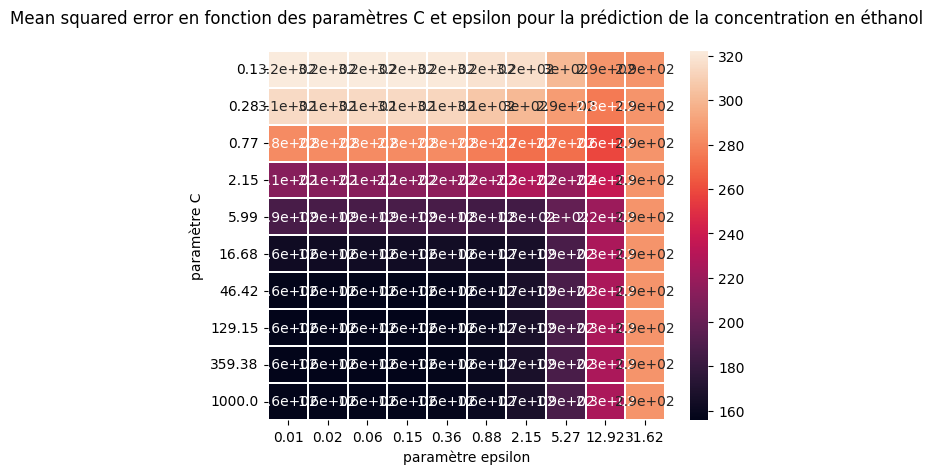

In [33]:
sns.heatmap(df_corr,annot=True,linewidths=.2)
plt.xlabel('paramètre epsilon')
plt.ylabel('paramètre C')
plt.title('Mean squared error en fonction des paramètres C et epsilon pour la prédiction de la concentration en éthanol',y=1.05)
plt.show()

Je conseille d'étendre l'image pour visualiser correctement la heatmap

Bien que la MSE reste élevé, on prend les hyper-paramètres C=17 et epsilon=0.3